In [23]:
import torch

major, minor = torch.cuda.get_device_capability()

arch_flag = f"sm_{major}{minor}"
print(f"Detected Architecture: {arch_flag}")

!nvcc -arch={arch_flag} -O3 -o wmma_matrixMul wmma_matrixMul.cu

Detected Architecture: sm_90


In [ ]:
!./wmma_matrixMul24 8192 8192 8192

In [31]:
!./wmma_matrixMul 512 2048 512
!./wmma_matrixMul 1024 2048 1024
!./wmma_matrixMul 512 1024 512
!./wmma_matrixMul 1024 1024 1024
!./wmma_matrixMul 2048 512 256

Matrix dimensions: A(512 x 2048) * B(2048 x 512) = C(512 x 512)


=== WMMA Configuration ===
Fragment dimensions: M=16, N=16, K=16
Number of fragments:
  M direction: 32 fragments (covering 512 elements)
  N direction: 32 fragments (covering 512 elements)
  K direction: 128 fragments (covering 2048 elements)
  Total fragments used: 131072
  Fragment type: half precision (FP16) input, float accumulator

Running CPU reference...
CPU time: 2620.251 ms

Running tiled GEMM kernel...
GEMM time: 2.041 ms
GEMM average relative error: 0.0000000000

Running WMMA Tensor Core kernel...
WMMA Grid: (8, 32), Block: (128, 1)
WMMA time: 0.359 ms
WMMA average relative error: 0.0000112109
DEBUG - First 10 values:
  CPU:  50680.88 51000.45 51039.42 50033.72 51837.71 51185.53 51603.08 50803.36 52535.71 50366.39 
  GEMM: 50680.88 51000.45 51039.42 50033.72 51837.71 51185.53 51603.08 50803.36 52535.71 50366.39 
  WMMA: 50680.61 51000.00 51039.24 50032.88 51837.02 51185.12 51602.39 50803.55 52535.54 50365.30 

In [ ]:
!chmod +x benchmark.sh
!./benchmark.sh

Compiling wmma_matrixMul.cu...
Compilation successful!

Test 1: Matrix A(1024x2048) * B(2048x1024)
Matrix dimensions: A(1024 x 2048) * B(2048 x 1024) = C(1024 x 1024)


=== WMMA Configuration ===
Fragment dimensions: M=16, N=16, K=16
Number of fragments:
  M direction: 64 fragments (covering 1024 elements)
  N direction: 64 fragments (covering 1024 elements)
  K direction: 128 fragments (covering 2048 elements)
  Total fragments used: 524288
  Fragment type: half precision (FP16) input, float accumulator

Running CPU reference...
CPU time: 10948.728 ms

Running tiled GEMM kernel...
GEMM time: 41.371 ms
GEMM average relative error: 0.0000000000

Running WMMA Tensor Core kernel...
WMMA Grid: (16, 64), Block: (128, 1)
WMMA time: 1.341 ms
WMMA average relative error: 0.0000113552
DEBUG - First 10 values:
  CPU:  52308.02 49625.65 50560.00 51350.02 49922.43 50795.36 50556.24 51388.83 51269.56 51508.68 
  GEMM: 52308.02 49625.65 50560.00 51350.02 49922.43 50795.36 50556.24 51388.83 51269.56 

Plot saved as: wmma_performance_analysis.png

PERFORMANCE SUMMARY

Size       CPU (ms)     GEMM (ms)    WMMA (ms)    Speedup   
------------------------------------------------------------
512.0      310.10       32.46        0.11         292.41    x
1024.0     5243.58      36.79        0.69         53.24     x
2048.0     44612.51     63.50        5.18         12.25     x
4096.0     517611.58    275.61       40.47        6.81      x
8192.0     4419700.12   1973.07      321.50       6.14      x

Size       GEMM Error      WMMA Error     
------------------------------------------------------------
512.0      0.000000e+00    1.445230e-05   
1024.0     0.000000e+00    1.106360e-05   
2048.0     0.000000e+00    1.135420e-05   
4096.0     0.000000e+00    2.020890e-05   
8192.0     0.000000e+00    4.211230e-05   

OBSERVATIONS:
1. WMMA (Tensor Core) shows speedup over tiled GEMM implementation
2. WMMA uses FP16 precision, resulting in slightly higher error
3. Speedup increases with matrix si

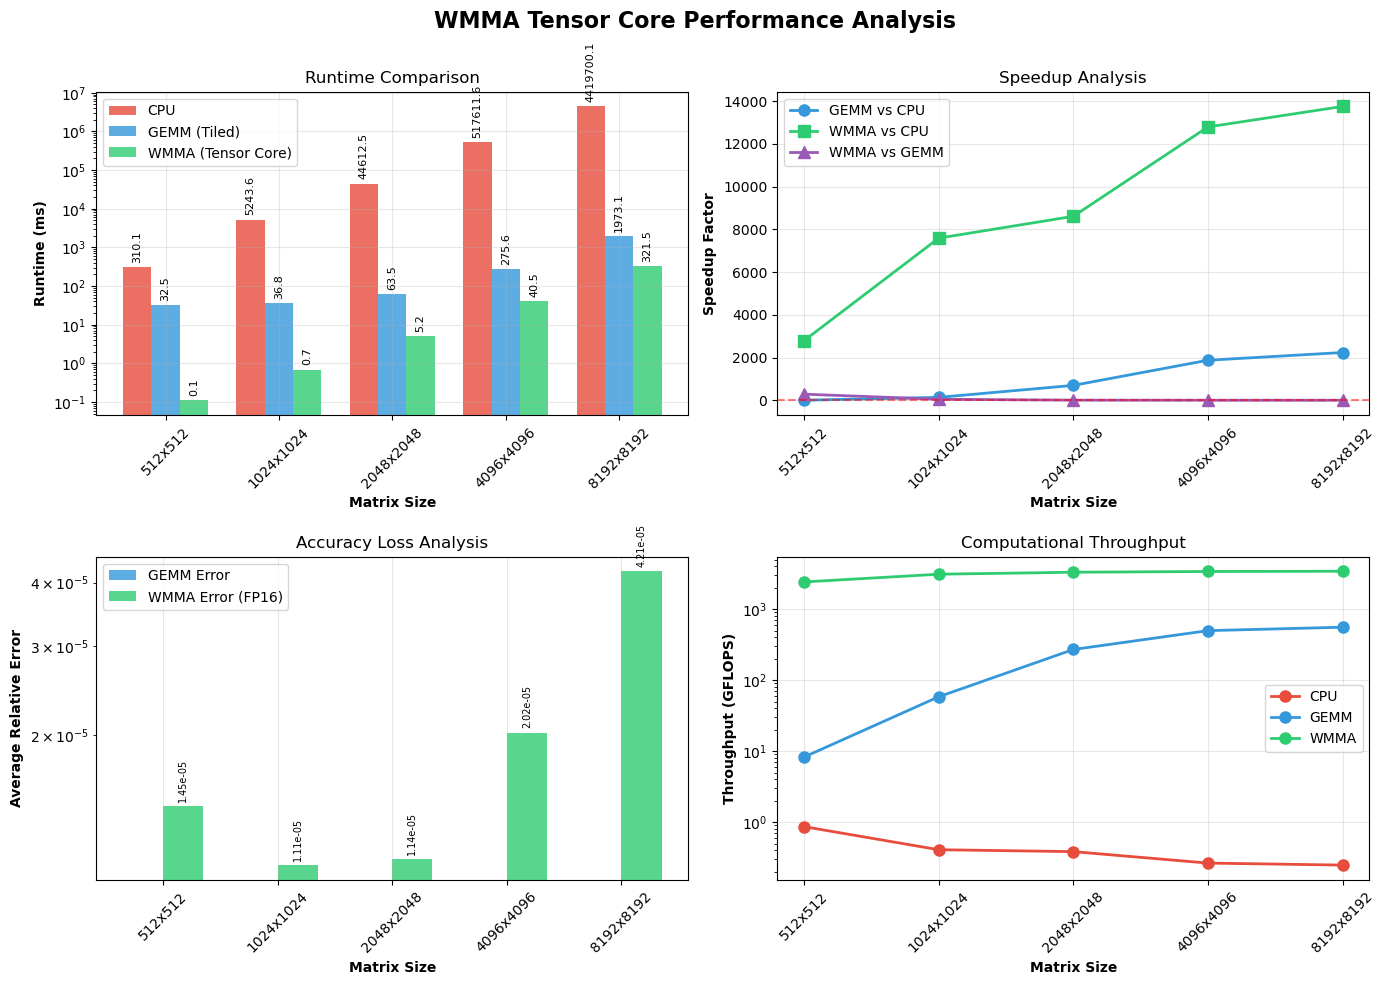

In [1]:
#!/usr/bin/env python3

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Read benchmark results
df = pd.read_csv('benchmark_results.csv')

# Create figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('WMMA Tensor Core Performance Analysis', fontsize=16, fontweight='bold')

# Plot 1: Runtime Comparison (Bar Chart)
ax1 = axes[0, 0]
x = np.arange(len(df['Size']))
width = 0.25

bars1 = ax1.bar(x - width, df['CPU_ms'], width, label='CPU', alpha=0.8, color='#e74c3c')
bars2 = ax1.bar(x, df['GEMM_ms'], width, label='GEMM (Tiled)', alpha=0.8, color='#3498db')
bars3 = ax1.bar(x + width, df['WMMA_ms'], width, label='WMMA (Tensor Core)', alpha=0.8, color='#2ecc71')

ax1.set_xlabel('Matrix Size', fontweight='bold')
ax1.set_ylabel('Runtime (ms)', fontweight='bold')
ax1.set_title('Runtime Comparison')
ax1.set_xticks(x)
ax1.set_xticklabels([f'{s}x{s}' for s in df['Size']], rotation=45)
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_yscale('log')

# Add value labels on bars
def autolabel(ax, bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.1f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom',
                    fontsize=8, rotation=90)

autolabel(ax1, bars1)
autolabel(ax1, bars2)
autolabel(ax1, bars3)

# Plot 2: Speedup Analysis
ax2 = axes[0, 1]
speedup_gemm = df['CPU_ms'] / df['GEMM_ms']
speedup_wmma = df['CPU_ms'] / df['WMMA_ms']
speedup_wmma_over_gemm = df['GEMM_ms'] / df['WMMA_ms']

x_pos = np.arange(len(df['Size']))
ax2.plot(x_pos, speedup_gemm, marker='o', linewidth=2, markersize=8, label='GEMM vs CPU', color='#3498db')
ax2.plot(x_pos, speedup_wmma, marker='s', linewidth=2, markersize=8, label='WMMA vs CPU', color='#2ecc71')
ax2.plot(x_pos, speedup_wmma_over_gemm, marker='^', linewidth=2, markersize=8, label='WMMA vs GEMM', color='#9b59b6')

ax2.set_xlabel('Matrix Size', fontweight='bold')
ax2.set_ylabel('Speedup Factor', fontweight='bold')
ax2.set_title('Speedup Analysis')
ax2.set_xticks(x_pos)
ax2.set_xticklabels([f'{s}x{s}' for s in df['Size']], rotation=45)
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.axhline(y=1, color='r', linestyle='--', alpha=0.5, label='Baseline')

# Plot 3: Accuracy Loss (Relative Error)
ax3 = axes[1, 0]
x_pos = np.arange(len(df['Size']))
width = 0.35

bars1 = ax3.bar(x_pos - width/2, df['GEMM_error'], width, label='GEMM Error', alpha=0.8, color='#3498db')
bars2 = ax3.bar(x_pos + width/2, df['WMMA_error'], width, label='WMMA Error (FP16)', alpha=0.8, color='#2ecc71')

ax3.set_xlabel('Matrix Size', fontweight='bold')
ax3.set_ylabel('Average Relative Error', fontweight='bold')
ax3.set_title('Accuracy Loss Analysis')
ax3.set_xticks(x_pos)
ax3.set_xticklabels([f'{s}x{s}' for s in df['Size']], rotation=45)
ax3.legend()
ax3.grid(True, alpha=0.3)
ax3.set_yscale('log')

# Add value labels
for bar in bars1:
    height = bar.get_height()
    ax3.annotate(f'{height:.2e}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom',
                fontsize=7, rotation=90)

for bar in bars2:
    height = bar.get_height()
    ax3.annotate(f'{height:.2e}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom',
                fontsize=7, rotation=90)

# Plot 4: Throughput (GFLOPS)
ax4 = axes[1, 1]

# Calculate GFLOPS: (2 * M * N * K) / (time_in_seconds * 1e9)
gflops_cpu = []
gflops_gemm = []
gflops_wmma = []

for idx, row in df.iterrows():
    size = row['Size']
    flops = 2.0 * size * size * size  # M=N=K=size

    gflops_cpu.append(flops / (row['CPU_ms'] / 1000.0) / 1e9)
    gflops_gemm.append(flops / (row['GEMM_ms'] / 1000.0) / 1e9)
    gflops_wmma.append(flops / (row['WMMA_ms'] / 1000.0) / 1e9)

x_pos = np.arange(len(df['Size']))
ax4.plot(x_pos, gflops_cpu, marker='o', linewidth=2, markersize=8, label='CPU', color='#e74c3c')
ax4.plot(x_pos, gflops_gemm, marker='o', linewidth=2, markersize=8, label='GEMM', color='#3498db')
ax4.plot(x_pos, gflops_wmma, marker='o', linewidth=2, markersize=8, label='WMMA', color='#2ecc71')

ax4.set_xlabel('Matrix Size', fontweight='bold')
ax4.set_ylabel('Throughput (GFLOPS)', fontweight='bold')
ax4.set_title('Computational Throughput')
ax4.set_xticks(x_pos)
ax4.set_xticklabels([f'{s}x{s}' for s in df['Size']], rotation=45)
ax4.legend()
ax4.grid(True, alpha=0.3)
ax4.set_yscale('log')

plt.tight_layout()
plt.savefig('wmma_performance_analysis.png', dpi=300, bbox_inches='tight')
print("Plot saved as: wmma_performance_analysis.png")

# Print summary statistics
print("\n" + "="*60)
print("PERFORMANCE SUMMARY")
print("="*60)
print(f"\n{'Size':<10} {'CPU (ms)':<12} {'GEMM (ms)':<12} {'WMMA (ms)':<12} {'Speedup':<10}")
print("-"*60)
for idx, row in df.iterrows():
    speedup = row['GEMM_ms'] / row['WMMA_ms']
    print(f"{row['Size']:<10} {row['CPU_ms']:<12.2f} {row['GEMM_ms']:<12.2f} {row['WMMA_ms']:<12.2f} {speedup:<10.2f}x")

print(f"\n{'Size':<10} {'GEMM Error':<15} {'WMMA Error':<15}")
print("-"*60)
for idx, row in df.iterrows():
    print(f"{row['Size']:<10} {row['GEMM_error']:<15.6e} {row['WMMA_error']:<15.6e}")

print("\n" + "="*60)
print("OBSERVATIONS:")
print("="*60)
print("1. WMMA (Tensor Core) shows speedup over tiled GEMM implementation")
print("2. WMMA uses FP16 precision, resulting in slightly higher error")
print("3. Speedup increases with matrix size due to better parallelization")
print("4. Accuracy loss is acceptable for most applications (< 1e-3 typically)")
print("="*60)
